<a href="https://colab.research.google.com/github/hetkothari/NYC-Taxi-Trip-Capstone-/blob/main/NYC_Taxi_Trip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem Description
Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

In [97]:
#Importing the libraries which will be required for this project.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV


#Mount Google Drive

In [98]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
data= pd.read_csv("/content/drive/MyDrive/NYC Taxi Data.csv")

Mounted at /content/drive


#Data Overview

In [99]:
data.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


In [100]:
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [101]:
data.info

<bound method DataFrame.info of                 id  vendor_id  ... store_and_fwd_flag trip_duration
0        id2875421          2  ...                  N           455
1        id2377394          1  ...                  N           663
2        id3858529          2  ...                  N          2124
3        id3504673          2  ...                  N           429
4        id2181028          2  ...                  N           435
...            ...        ...  ...                ...           ...
1458639  id2376096          2  ...                  N           778
1458640  id1049543          1  ...                  N           655
1458641  id2304944          2  ...                  N           764
1458642  id2714485          1  ...                  N           373
1458643  id1209952          1  ...                  N           198

[1458644 rows x 11 columns]>

In [102]:
data["trip_duration"].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

In [103]:
data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [104]:
data.isnull().sum()


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [105]:
data['pickup'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff'] = pd.to_datetime(data['dropoff_datetime'])

In [106]:
data = data.drop(["pickup_datetime"],axis=1)
data = data.drop(["dropoff_datetime"],axis=1)

In [107]:
data

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup,dropoff
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14 17:24:55,2016-03-14 17:32:30
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12 00:43:35,2016-06-12 00:54:38
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19 11:35:24,2016-01-19 12:10:48
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06 19:32:31,2016-04-06 19:39:40
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26 13:30:55,2016-03-26 13:38:10
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08 13:31:04,2016-04-08 13:44:02
1458640,id1049543,1,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10 07:35:15,2016-01-10 07:46:10
1458641,id2304944,2,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22 06:57:41,2016-04-22 07:10:25
1458642,id2714485,1,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05 15:56:26,2016-01-05 16:02:39


In [108]:
from geopy.distance import great_circle
def cal_distance(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
 
 start_coordinates=(pickup_lat,pickup_long)
 stop_coordinates=(dropoff_lat,dropoff_long)
 
 return great_circle(start_coordinates,stop_coordinates).km

In [109]:
data['distance'] = data.apply(lambda x: cal_distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude'] ), axis=1)

In [110]:
data['speed'] = (data.distance/(data.trip_duration/3600))

In [113]:
data['pickupday']=data['pickup'].dt.day_name()
data['pickuphour']=data['pickup'].dt.hour

In [114]:
dummy = pd.get_dummies(data.store_and_fwd_flag, prefix='store_and_fwd_flag')
data = pd.concat([data,dummy], axis = 1)
dummy = pd.get_dummies(data.pickupday, prefix='pickupday')
data = pd.concat([data,dummy], axis = 1)
dummy = pd.get_dummies(data.pickuphour, prefix='pickuphour')
data = pd.concat([data,dummy], axis = 1)

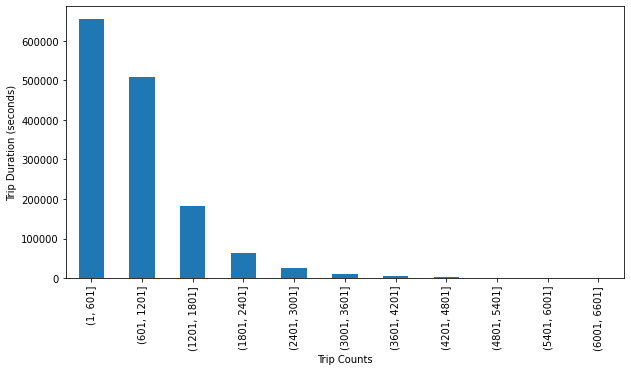

In [38]:
plt.figure(figsize = (10,5))
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,7200,600))).count().plot(kind='bar')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()


In [115]:
data = data[data.trip_duration <= 4200]
data = data[data.trip_duration >= 60]

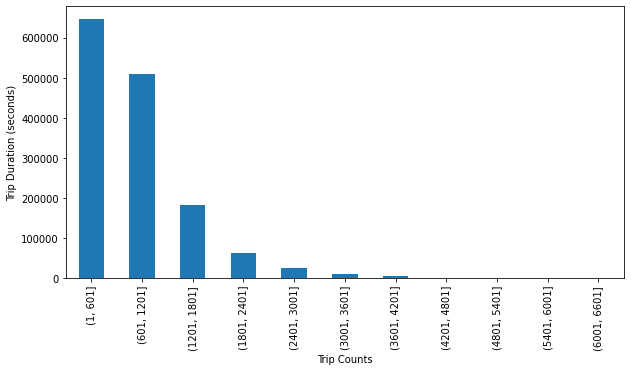

In [40]:
plt.figure(figsize = (10,5))
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,7200,600))).count().plot(kind='bar')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()


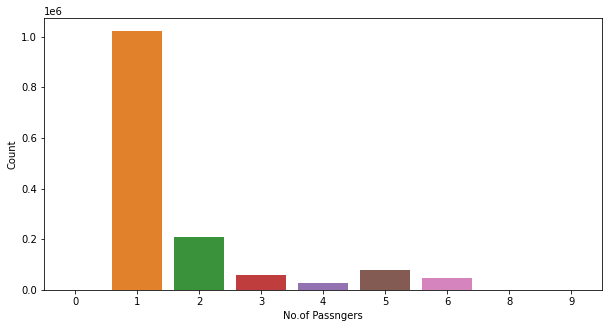

In [41]:
plt.figure(figsize = (10,5))
sns.countplot(x='passenger_count',data=data)
plt.ylabel('Count')
plt.xlabel('No.of Passngers')
plt.show()

In [42]:
data['store_and_fwd_flag'].value_counts(normalize=True)

N    0.9946
Y    0.0054
Name: store_and_fwd_flag, dtype: float64

In [116]:
data=data.drop(["store_and_fwd_flag_N"],axis=1)

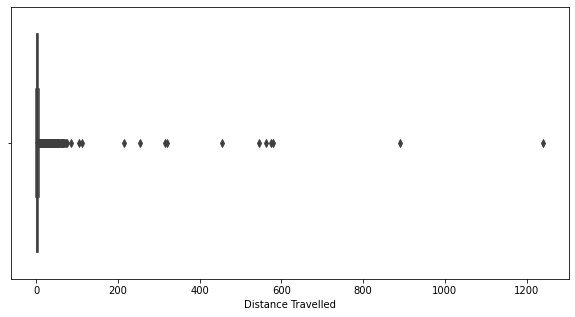

In [117]:
plt.figure(figsize = (10,5))
sns.boxplot(data.distance)
plt.xlabel('Distance Travelled')
plt.show()

In [118]:
data = data[~(data.distance > 80)]
data = data[~(data.distance < 2)]

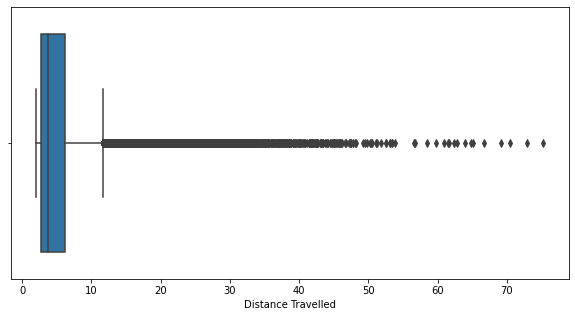

In [119]:
plt.figure(figsize = (10,5))
sns.boxplot(data.distance)
plt.xlabel('Distance Travelled')
plt.show()

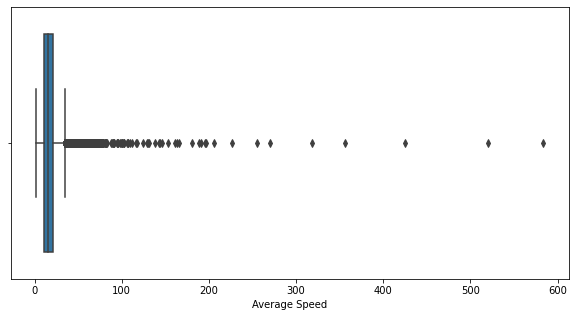

In [48]:
plt.figure(figsize = (10,5))
sns.boxplot(data.speed)
plt.xlabel('Average Speed')
plt.show()

In [120]:
data = data[~(data.speed >40)]
data = data[~(data.speed <3)]

In [57]:
data.info

<bound method DataFrame.info of                 id  vendor_id  ...  store_and_fwd_flag_N  store_and_fwd_flag_Y
2        id3858529          2  ...                     1                     0
7        id1324603          2  ...                     1                     0
9        id0012891          2  ...                     1                     0
10       id1436371          2  ...                     1                     0
11       id1299289          2  ...                     1                     0
...            ...        ...  ...                   ...                   ...
1458634  id3445276          1  ...                     1                     0
1458637  id1920898          1  ...                     1                     0
1458638  id1454193          2  ...                     1                     0
1458640  id1049543          1  ...                     1                     0
1458641  id2304944          2  ...                     1                     0

[741259 rows x 16 c

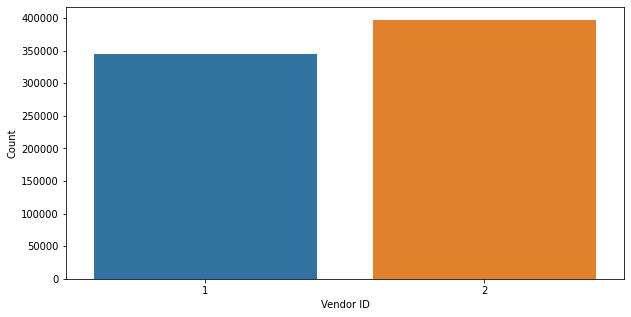

In [58]:
plt.figure(figsize = (10,5))
sns.countplot(data.vendor_id)
plt.xlabel('Vendor ID')
plt.ylabel('Count')
plt.show()

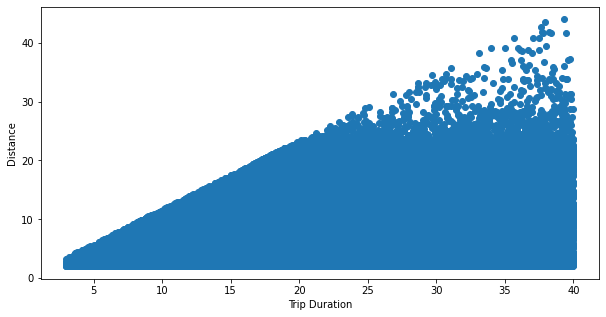

In [59]:
plt.figure(figsize = (10,5))
plt.scatter(x='speed', y='distance',data=data)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()

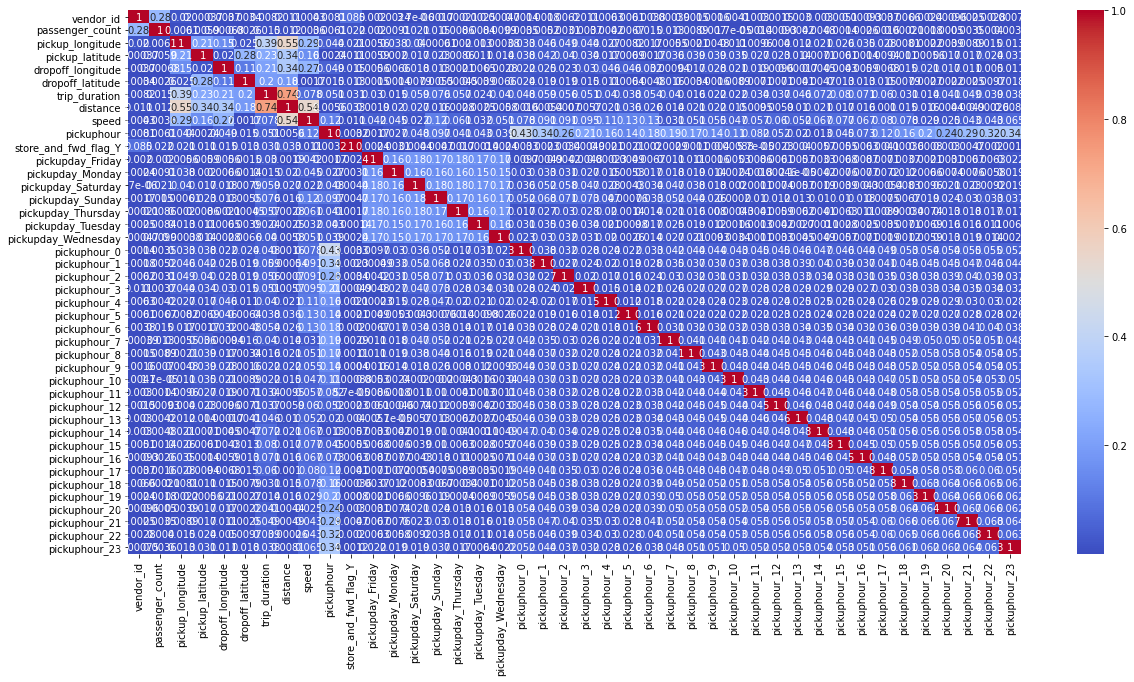

In [121]:
plt.figure (figsize= (20,10))
corelation= data.corr()
sns.heatmap(abs(corelation), annot=True, cmap='coolwarm')

In [ ]:
data=data.drop(["pickup_longitude",	"pickup_latitude",	"dropoff_longitude",	"dropoff_latitude","store_and_fwd_flag_Y"],axis=1)

In [137]:
data=data.drop(["store_and_fwd_flag","id","pickup","dropoff","pickupday"],axis=1)


In [138]:
df_min_max_scaled = data
df_min_max_scaled

,vendor_id,passenger_count,trip_duration,distance,speed,pickuphour,pickupday_Friday,pickupday_Monday,pickupday_Saturday,pickupday_Sunday,pickupday_Thursday,pickupday_Tuesday,pickupday_Wednesday,pickuphour_0,pickuphour_1,pickuphour_2,pickuphour_3,pickuphour_4,pickuphour_5,pickuphour_6,pickuphour_7,pickuphour_8,pickuphour_9,pickuphour_10,pickuphour_11,pickuphour_12,pickuphour_13,pickuphour_14,pickuphour_15,pickuphour_16,pickuphour_17,pickuphour_18,pickuphour_19,pickuphour_20,pickuphour_21,pickuphour_22,pickuphour_23
2,2,1,2124,6.385108,10.822216,11,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7,2,1,1551,5.714989,13.264964,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2,1,1225,5.121169,15.049965,21,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10,2,1,1274,3.806145,10.755197,22,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11,2,4,1128,3.773101,12.041813,11,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458634,1,2,972,5.258996,19.477764,13,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1458637,1,1,760,3.537560,16.756863,18,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1458638,2,5,414,2.317452,20.151754,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1458640,1,1,655,6.049844,33.251052,7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [139]:
for column in df_min_max_scaled.columns:
    df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())   

In [140]:
df_min_max_scaled


,vendor_id,passenger_count,trip_duration,distance,speed,pickuphour,pickupday_Friday,pickupday_Monday,pickupday_Saturday,pickupday_Sunday,pickupday_Thursday,pickupday_Tuesday,pickupday_Wednesday,pickuphour_0,pickuphour_1,pickuphour_2,pickuphour_3,pickuphour_4,pickuphour_5,pickuphour_6,pickuphour_7,pickuphour_8,pickuphour_9,pickuphour_10,pickuphour_11,pickuphour_12,pickuphour_13,pickuphour_14,pickuphour_15,pickuphour_16,pickuphour_17,pickuphour_18,pickuphour_19,pickuphour_20,pickuphour_21,pickuphour_22,pickuphour_23
2,1.0,0.166667,0.483325,0.104517,0.211402,0.478261,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.166667,0.340717,0.088545,0.277423,0.304348,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.166667,0.259582,0.074392,0.325667,0.913043,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10,1.0,0.166667,0.271777,0.043049,0.209590,0.956522,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11,1.0,0.666667,0.235441,0.042261,0.244364,0.478261,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458634,0.0,0.333333,0.196615,0.077677,0.445340,0.565217,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1458637,0.0,0.166667,0.143853,0.036647,0.371801,0.782609,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1458638,1.0,0.833333,0.057740,0.007566,0.463556,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1458640,0.0,0.166667,0.117720,0.096526,0.817598,0.304348,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
x = data
x= x.drop(["speed","trip_duration"],axis=1)

In [146]:
y= data["trip_duration"]
y

2          0.483325
7          0.340717
9          0.259582
10         0.271777
11         0.235441
             ...   
1458634    0.196615
1458637    0.143853
1458638    0.057740
1458640    0.117720
1458641    0.144848
Name: trip_duration, Length: 741259, dtype: float64

In [149]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=0)

In [150]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
#Cross validation
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-10,1e-5,1e-3,1e-2,1,10,30,45,55]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-05, 0.001, 0.01, 1, 10, 30,
                                   45, 55]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [151]:
print('The best fit alpha value is found out to be :', lasso_regressor.best_params_)
print('The R2 score using the same alpha is :', lasso_regressor.best_score_)
y_pred_lasso_train = lasso_regressor.predict(X_train)
y_pred_lasso_test = lasso_regressor.predict(X_test)


The best fit alpha value is found out to be : {'alpha': 1e-15}
The R2 score using the same alpha is : 0.6142314569454321


In [155]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


lasso_train_mse  = mean_squared_error(y_train, y_pred_lasso_train)
print("Train MSE :" , lasso_train_mse)

lasso_train_rmse = np.sqrt(lasso_train_mse)
print("Train RMSE :" ,lasso_train_rmse)

lasso_train_r2 = r2_score(y_train, y_pred_lasso_train)
print("Train R2 :" ,lasso_train_r2)

lasso_train_r2_= 1-(1-r2_score(y_train, y_pred_lasso_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", lasso_train_r2)

Train MSE : 0.009922879248800658
Train RMSE : 0.099613649912051
Train R2 : 0.6142980112106222
Train Adjusted R2 :  0.6142980112106222


In [156]:
lasso_test_mse  = mean_squared_error(y_test, y_pred_lasso_test)
print("Test MSE :" , lasso_test_mse)

lasso_test_rmse = np.sqrt(lasso_test_mse)
print("Test RMSE :" ,lasso_test_rmse)

lasso_test_r2 = r2_score(y_test, y_pred_lasso_test)
print("Test R2 :" ,lasso_test_r2)

lasso_test_r2_= 1-(1-r2_score(y_test, y_pred_lasso_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", lasso_test_r2_)

Test MSE : 0.009964146347201277
Test RMSE : 0.09982057076174869
Test R2 : 0.6107429817562373
Test Adjusted R2 :  0.6106970274015059
